In [1]:
library(tidyverse)
library(ggplot2)
library(kableExtra)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
install.packages("e1071")
library(e1071)
churn <- read_csv("../_build/data/churn_train.csv")
cvConditions <- trainControl(method = "cv", number = 5)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Warning message:
"package 'kableExtra' was built under R version 3.6.3"


Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



Loading required package: lattice



Attaching package: 'caret'



The following object is masked from 'package:purrr':

    lift



randomForest 4.6-14


Type rfNews() to see new features/changes/bug fixes.



Attaching package: 'randomForest'



The following object is masked from 'package:dplyr':

    combine



The following object is masked from 'package:ggplot2':

    margin




  There is a binary version available but the source version is later:
      binary source needs_compilation
e1071  1.7-6  1.7-9              TRUE

  Binaries will be installed
package 'e1071' successfully unpacked and MD5 sums checked



The downloaded binary packages are in
	C:\Users\phamilton\AppData\Local\Temp\RtmpsDS5I3\downloaded_packages


Warning message:
"package 'e1071' was built under R version 3.6.3"

Parsed with column specification:
cols(
  account_length = col_double(),
  international_plan = col_character(),
  voice_mail_plan = col_character(),
  number_vmail_messages = col_double(),
  total_day_minutes = col_double(),
  total_day_calls = col_double(),
  total_night_minutes = col_double(),
  total_night_calls = col_double(),
  total_intl_minutes = col_double(),
  total_intl_calls = col_double(),
  total_intl_charge = col_double(),
  number_customer_service_calls = col_double(),
  churn = col_character()
)


# Decision Trees

**Classification and regression tree (CART) models** are a popular class of machine learning algorithms that make predictions according to a set of logical rules learned from training data. Tree models that predict discrete outcomes are referred to as **classification trees**, while tree models that predict continuous outcomes are referred to as **regression trees**. 

One major advantage of CART models is their interpretability. As we will see, CART models make predictions according to a series of logical rules that can be analyzed and understood by human users. This is in contrast to many other algorithms (like the random forest model discussed in the next section), which are more difficult to interpret.

## Classification Trees

To understand classification trees, let's start with a simplified version of our `churn` data set that only has twelve observations and two independent features, `total_intl_charge` and `account_length`. Our feature space looks as follows:

Parsed with column specification:
cols(
  account_length = col_double(),
  total_intl_charge = col_double(),
  churn = col_double()
)


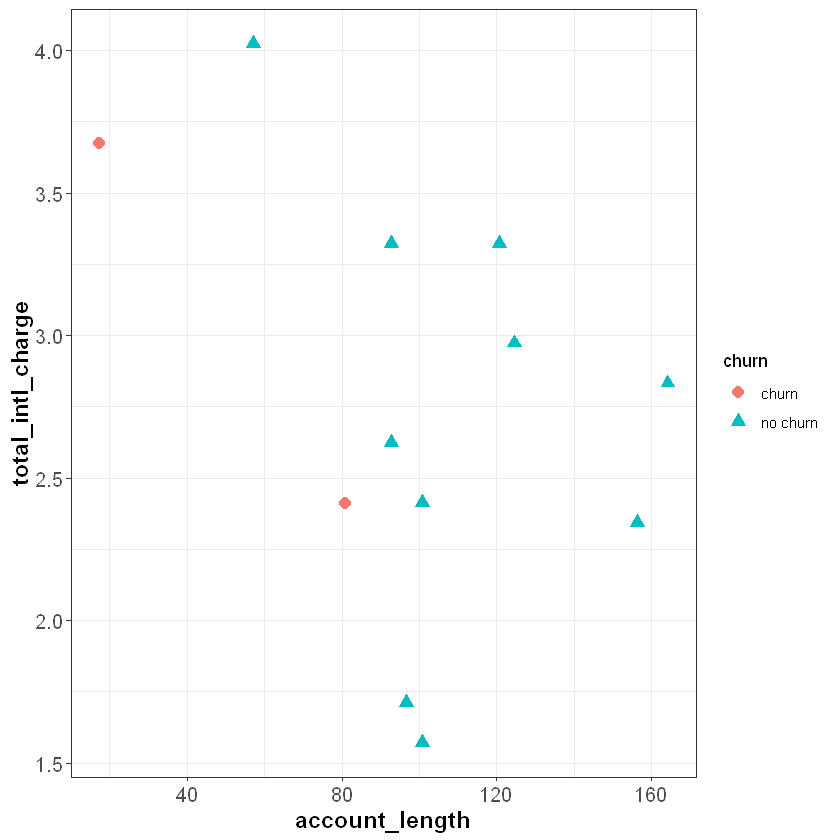

In [2]:
churnSample <- read_csv("../_build/data/churn_sample2.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)
library(ggplot2)

ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

The classification tree algorithm works by drawing a straight line that partitions the feature space to maximize the homogeneity (or minimize the entropy) of each sub-region. For example, imagine we drew a vertical line at around `account_length` = 87, dividing the feature space into **R1** and **R2**. Intuitively, R2 is completely homogeneous because it only contains observations with the same outcome—"no churn". R1 is less homogeneous because it contains two "churn" observations and one "no churn" observation.

Parsed with column specification:
cols(
  account_length = col_double(),
  total_intl_charge = col_double(),
  churn = col_double()
)


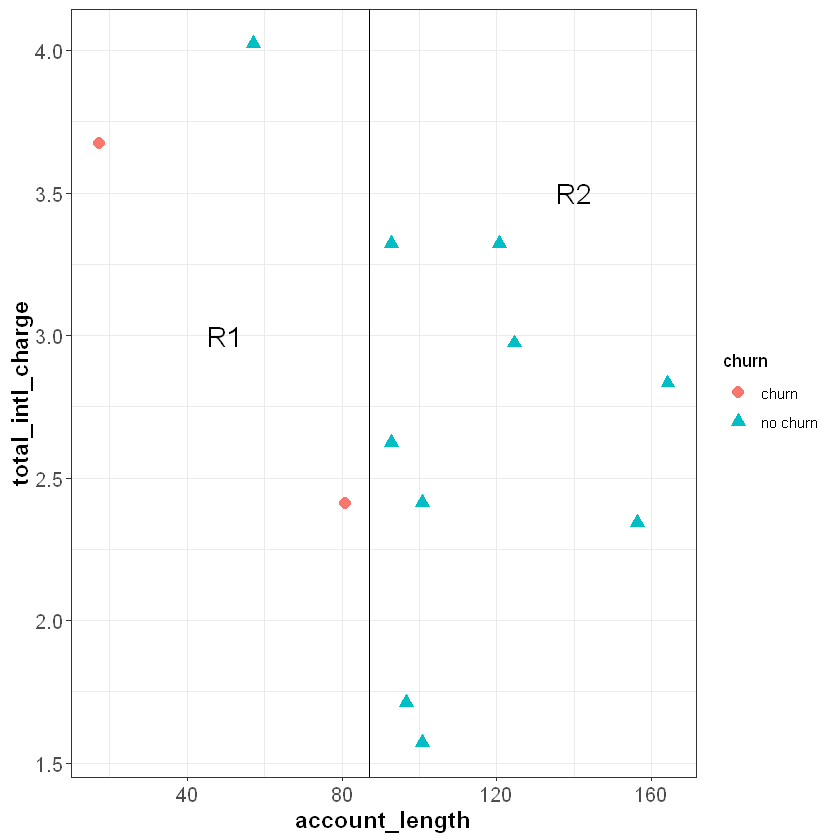

In [3]:
churnSample <- read_csv("../_build/data/churn_sample2.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)

ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
    geom_vline(xintercept = 87) + 
  annotate("text", x = 50, y = 3, label = "R1", size=6) + 
  annotate("text", x = 140, y = 3.5, label = "R2", size=6)

In this simple example we made cuts based on a visual inspection of the data, but the classification tree algorithm uses a measure known as **entropy** to ensure that each cut maximizes the homogeneity of the resulting subspaces. Entropy is defined as follows:

$$Entropy = -\sum_i^C{p_ilog(p_i)}$$

where the data set has $C$ classes (or unique outcome values), and $p_i$ represents the proportion of observations in the data from the $i$th class. In our case $C=2$ because we have two classes: "churn" and "no churn". Notice, this is very similar to the log loss formula that we introduced in [Log Loss](../09_model_eval/performance_metrics.html#log-loss). 

Using this formula, we can first calculate the entropy of our original data set (before we made any cuts), which we'll call $E_0$. There are two "churn" customers and ten "no churn" customers, so the entropy is:

$$E_0 = -[\frac{2}{12}log(\frac{2}{12}) + \frac{10}{12}log(\frac{10}{12})] = 0.1957$$

Now we will calculate the entropy after making the cut, for each subspace separately. The subspace **R2** is completely homogeneous (all nine customers are "no churn"), so the entropy equals zero:

$$E_{R2} = -[\frac{9}{9}log(\frac{9}{9})] = 0$$

The subspace $R1$ has one "no churn" and two "churns", so the entropy equals:

$$E_{R1} = -[\frac{2}{3}log(\frac{2}{3}) + \frac{1}{3}log(\frac{1}{3})] = 0.2764$$

To calculate the overall entropy after making the cut at `account_length` = 87, we take a weighted average of $E_{R1}$ and $E_{R2}$ based on the number of observations in each subspace:

$$E_{Cut1} = \frac{3}{12}E_{R1} + \frac{9}{12}E_{R2} = 0.0691$$

The **information gain**, or the reduction in entropy due to this cut, is then:
$$E_0 - E_{Cut1} = 0.1957 - 0.0691 = 0.1266$$ 

Each cut is made at the point that will result in the greatest reduction in the information gain. To further reduce the entropy of **R1**, we can make a cut around `total_intl_charge` = 3.8 to partition **R1** into two smaller regions (**R3** and **R4**) that are completely homogeneous. Because the feature space is completely divided into pure regions, the entropy after the second cut is zero:

$$\begin{aligned}E_{Cut2} & = \frac{9}{12}E_{R2} + \frac{2}{12}E_{R3} + \frac{1}{12}E_{R4} \\ & = \frac{9}{12}(0) + \frac{2}{12}(0) + \frac{1}{12}(0) \\ & = 0
\end{aligned}$$

Parsed with column specification:
cols(
  account_length = col_double(),
  total_intl_charge = col_double(),
  churn = col_double()
)


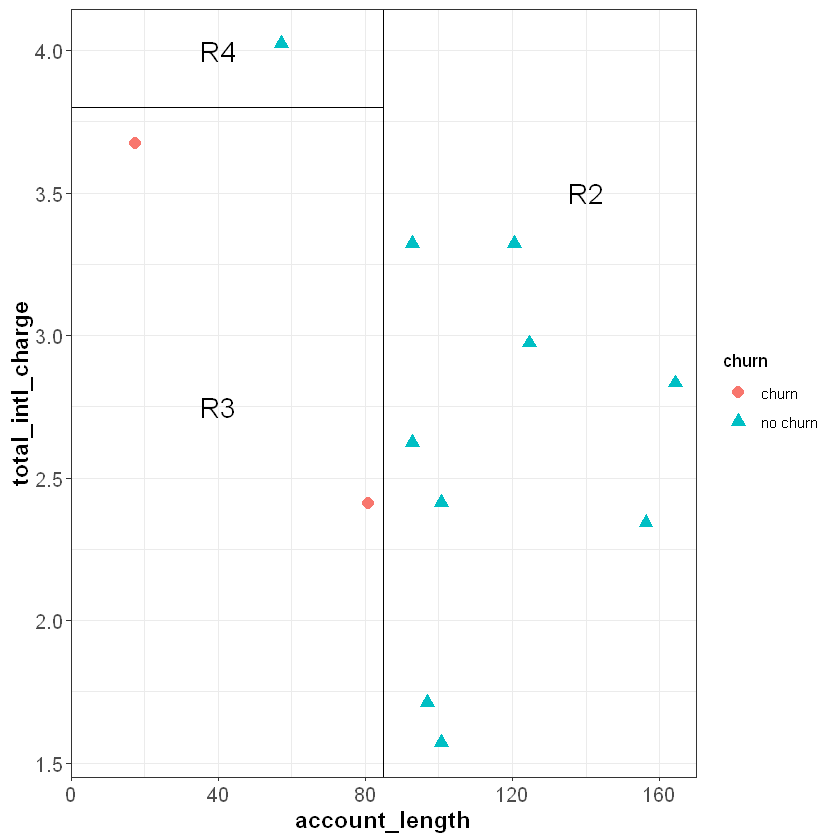

In [4]:
churnSample <- read_csv("../_build/data/churn_sample2.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)

ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
    geom_vline(xintercept = 85) + 
  annotate("text", x = 140, y = 3.5, label = "R2", size=6) + 
  annotate("text", x = 40, y = 4, label = "R4", size=6) + 
  annotate("text", x = 40, y = 2.75, label = "R3", size=6) + 
  geom_segment(aes(x = 0, y = 3.8, xend = 85, yend = 3.8), color="black") +
  scale_x_continuous(limits = c(0, 170), expand = c(0, 0))
  

Because each subspace is completely pure, there are no additional cuts we could make to further reduce the entropy. 

To create pure feature space, we first made a cut at `account_length` = 87, then within the region where `account_length` was less than 87 made an additional cut at `total_intl_charge` = 3.8.  From this we can write out a set of decision rules:

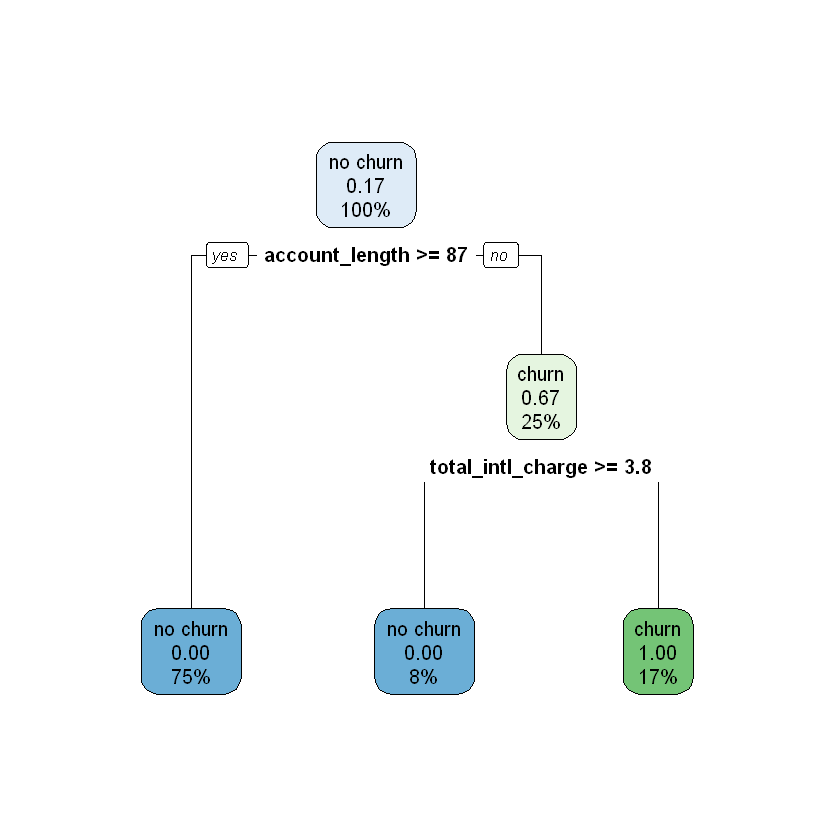

In [5]:
thing <- churnSample
thing$churn <- factor(thing$churn, levels=c("churn", "no churn"))
thing$churn <- ordered(thing$churn, levels = c("no churn", "churn"))
modelDT1 <- rpart(churn ~ ., data = thing, minsplit = 1)
rpart.plot(modelDT1)

We can use this decision tree to predict whether or not a new observation will churn. For example:

+ If a new observation has an `account_length` greater than or equal to 87, we move down the left branch of the tree and predict "no churn". 
+ If a new observation has an `account_length` less than 87 and a `total_intl_charge` greater than or equal to 3.8, we would move right at the first split and left at the second split of the tree, leading to a prediction of "no churn". 
+ If a new observation has an `account_length` less than 87 and a `total_intl_charge` less than 3.8, we would move right at the first split and right at the second split of the tree, leading to a prediction of "churn".

How do we interpret the numbers shown in the tree? In the plot each node has three rows, showing (in order):

+ The majority class in that node ("churn" / "no churn").
+ The proportion of the observations in that node that churned.
+ The percentage of the total data inside that node.

For example, let's start at the top node, which represents the data set before any cuts have been made. Because no cuts have been made, this node includes all of the data, so the third line shows 100%. Of the twelve observations in the data set, two of them churned, so the proportion of observations that churned equals (2 / 12) $\approx$ 0.17. Because this proportion is lower than the default cutoff of 0.5, the majority class for this node is "no churn". 

Now imagine what happens as we work our way down the tree. If `account_length` is greater than or equal to 87 we move to the left branch. This corresponds to the subspace R2 in the plot of the feature space. This subspace contains nine observations, or 75% of the total observations in the data set ((9 / 12) = 75%). None of these observations churned, so the second line in the node is 0.00, and the majority class is "no churn". 

Now imagine we work our way down the right branch of the tree. If `account_length` is less than 87, we move into the subspace R1. R1 has three observations ((3 / 12) = 25%), two of which churned ((2 / 3) $\approx$ 0.67). From this node, if `total_intl_charge` is less than 3.8 we move to the right, which represents subspace R3. Here we have two observations ((2 / 12) $\approx$ 17%), both of which churned ((2 / 2) = 1.00). If instead `total_intl_charge` is greater than or equal to 3.8 we move to the left, which represents subspace R4. Here we have one observation ((1 / 12) $\approx$ 8%), which did not churn ((0 / 1) = 0.00).

In R, we can fit a classification tree to our data using the `rpart()` function from the `rpart` package. This function uses the following syntax:

```{admonition} Syntax
`rpart::rpart(y ~ x1 + x2 + ... + xp, data, maxdepth = 30)`
+ *Required arguments*
  - `y`: The name of the dependent ($Y$) variable.
  - `x1`, `x2`, ... `xp`: The name of the first, second, and $pth$ independent variables.
  - `data`: The name of the data frame with the `y`, `x1`, `x2`, and `xp` variables.
+ *Optional arguments*
  - `maxdepth`: The maximum depth of the tree (see [Tuning Hyperparameters](decision_trees.html#tuning-hyperparameters) below).
```

Then, after we have built a model with `rpart()`, we can visualize the tree with the `rpart.plot()` function from the `rpart.plot` package:

```{admonition} Syntax
`rpart.plot::rpart.plot(x)`
+ *Required arguments*
  - `x`: A tree model built with `rpart()`.
```

Below we apply these functions to our full `churn` data set:

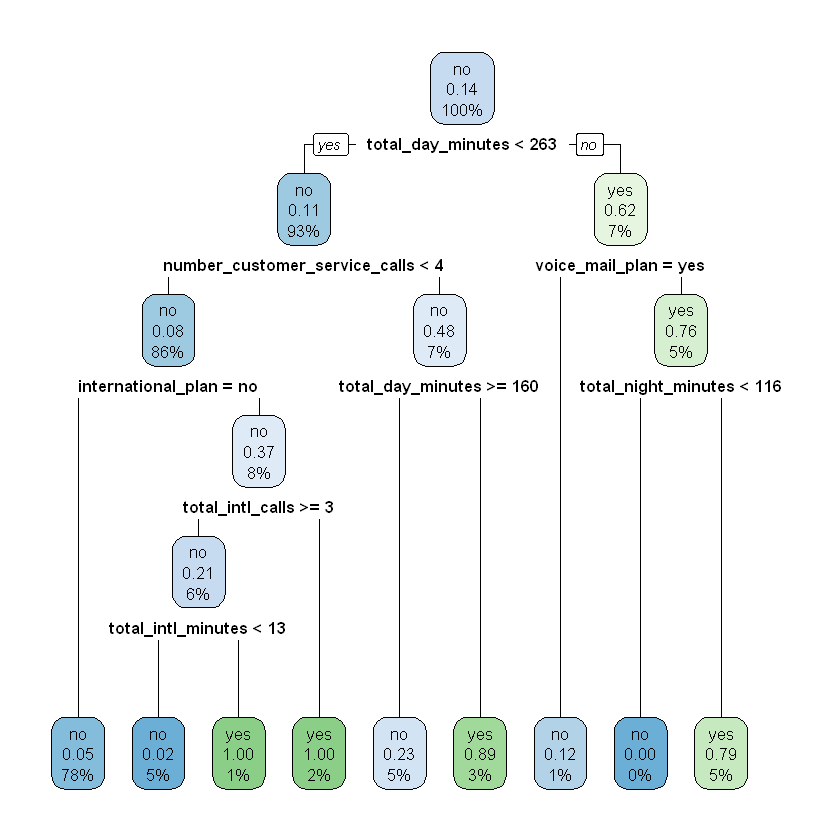

In [6]:
model <- rpart(churn ~ ., data = churn)
rpart.plot(model)

### Tuning Hyperparameters

Let's return to the simplified data set from the previous section, with only twelve observations and two features. After inspecting the classification tree we built from this data, you may suspect that something is wrong with the right branch - customers with a higher `total_intl_charge` are classified as "no churn", while customers with a lower `total_intl_charge` are classified as "churn". Based on the context of the business we may find this pattern surprising, as we expect customers with high international charges to be *more* likely to switch services. One possibility is that we are overfitting the data, so the decision tree is picking up on the noise in the sample instead of the signal.

To prevent overfitting, we can **prune** the decision tree to a certain depth; or, in other words, limit how many cuts we can perform. For example, let us prune this tree to a depth of one, meaning the algorithm cannot make more than one cut. The resulting pruned tree is shown below. Under this set of rules, customers with an `account_length` greater than or equal to 87 are classified as "no churn"; this is because subspace R2 (which represents `account_length` >= 87) contains only "no churn" observations. Customers with an `account_length` less than 87 are assigned a probability of churning of 0.67; this is because subspace R1 (which represents `account_length` < 87) contains two "churn" observations and one "no churn" observation ((2 / 3) $\approx$ 0.67). 

For CART models, the **depth** hyperparameter serves a similar purpose as the $k_{knn}$ hyperparameter for the kNN algorithm. By tuning the value of the tree's depth, we seek to balance the bias-variance tradeoff. If the depth is too large, our tree will grow too deep and overfit the training data. Conversely, if the depth is too small, our tree will not grow deep enough and will underfit the training data. Therefore, we need to use cross validation to identify the value of depth that balances this tradeoff on our data.

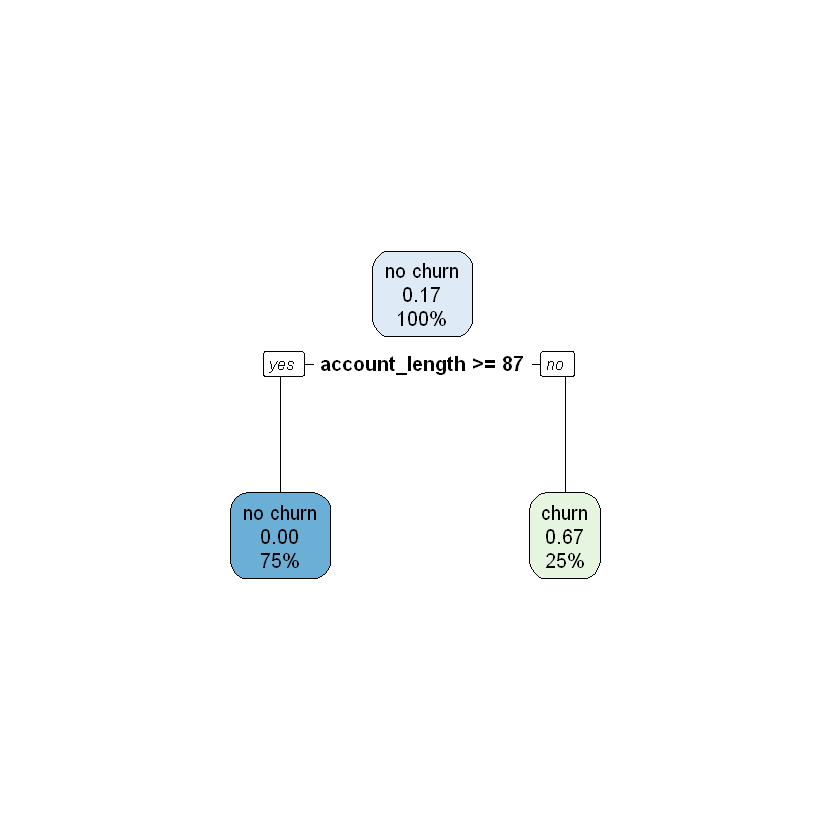

In [7]:
thing <- churnSample
thing$churn <- factor(thing$churn, levels=c("churn", "no churn"))
thing$churn <- ordered(thing$churn, levels = c("no churn", "churn"))
modelDT2 <- rpart(churn ~ ., data = thing, minsplit = 0, maxdepth=1)#
rpart.plot(modelDT2)

In R, we can tune the depth hyperparameter through cross validation using the exact same functions shown in the previous chapter. To train a cross-validated classification tree, we can use the `train()` function from the `caret` package just as we did in the previous chapter ([$k$-Fold Cross Validation](../09_model_eval/data_partition.html#k-fold-cross-validation)). To apply this function with the classification tree algorithm:

+ As before, we specify the independent and dependent variables in our model using the tilde (`~`). Remember that if you just replace the names of the features with the wildcard character `.`, the model will be built using all of the features in the data set. 
+ Because the classification tree algorithm does not require the data to be normalized like kNN, we can pass in the data set `churn` instead of `churnScaled`. 
+ To apply the classification tree algorithm, we set the `method` argument equal to `"rpart2"`. 
+ Recall that in [$k$-Fold Cross Validation](../09_model_eval/data_partition.html#k-fold-cross-validation) we created an object called `cvConditions`, which is used to ensure that for each model we test, the cross validation process is performed consistently. We can re-use that object here so we can directly compare these results to the results from the kNN model.

By default, the `train()` function comes up with a grid of different hyperparameter values to test.

In [8]:
set.seed(972945)
rpartCV <- train(churn ~ ., 
                 data = churn,
                 method = "rpart2", 
                 trControl = cvConditions)

rpartCV

CART 

3400 samples
  12 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2720, 2720, 2719, 2720, 2721 
Resampling results across tuning parameters:

  maxdepth  Accuracy   Kappa    
  1         0.8720613  0.3290213
  2         0.8823554  0.3917376
  4         0.9161777  0.5991045

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was maxdepth = 4.

Based on these results the optimal value of `maxdepth` is four, so our final tree will be pruned to a depth of four. We can visualize this tree by applying the `rpart.plot()` function to `rpartCV$finalModel`:

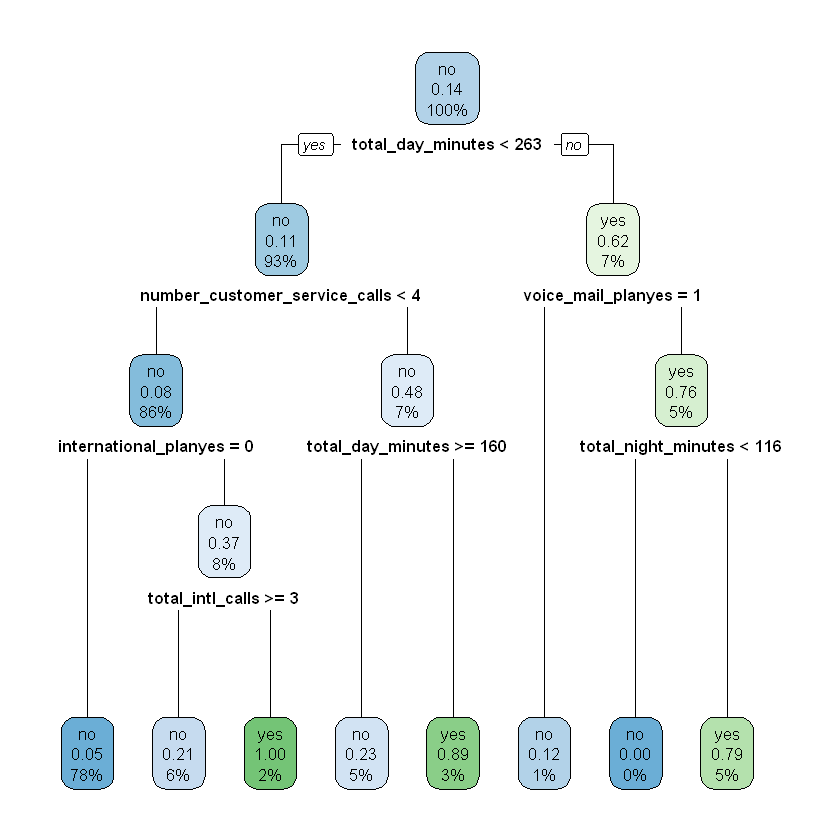

In [9]:
rpart.plot(rpartCV$finalModel)

## (&sect;) Regression Trees

[In Progress]